In [ ]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!pip install torchinfo
!pip install prettytable
!pip install torch_lr_finder

Add all the imports

In [1]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_10")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions, print_train_log
from custom_resnet.custom_resnet import CustomResnet, model_summary
from custom_resnet.data_loader import load_cifar10_data
from custom_resnet.training import training_loop
from custom_resnet.inference import model_test
from custom_resnet.optimizer import Optimization, find_best_lr


/home/jyani/.local/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Allocate GPU

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
resnet_model = CustomResnet(base_channels=3,num_classes=10).to(device)
model_summary(resnet_model, input_size=(3,32,32))



Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
CustomResnet                             --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Sequential: 1-1                        --                        [1, 3, 32, 32]            [1, 64, 32, 32]           --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
│    └─BatchNorm2d: 2-2                  --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    └─ReLU: 2-3                         --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
├─Layer: 1-2                             --                        --                        --  

/home/jyani/ERA_V1/session_10/custom_resnet/custom_resnet.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [3]:
train_transforms = A.Compose(
    [
        #A.augmentations.crops.transforms.RandomCrop(4,4),
        A.HorizontalFlip(p=0.5),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [4]:
torch.manual_seed(1)
batch_size = 512
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Show sample Images from the dataset

TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


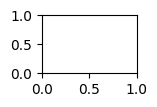

In [6]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

In [ ]:
drop_out = 0.05
num_epochs=24
resnet_model = CustomResnet(base_channels=3, num_classes=10, drop_out_probability = drop_out).to(device)
criterion = nn.CrossEntropyLoss()
optim_obj = Optimization(resnet_model, device, train_loader, criterion)
#find_best_lr(resnet_model, train_loader, optim_obj.optimizer, criterion, device)


In [ ]:
optim_obj.define_scheduler(max_lr=5.38E-2)
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = training_loop(resnet_model, device, train_loader, optim_obj.optimizer, criterion, train_acc, train_losses)
    this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
target_test_acc = 93.


Plot results for Batch Norm experiment

In [ ]:
plot_statistics(train_losses, train_acc, test_losses, test_acc, target_test_acc)
incorrect_predictions_bn = get_incorrect_predictions(resnet_model, test_loader, device)
show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)

Print Training Log

In [ ]:
print_train_log(train_acc, test_acc, train_losses, test_losses)